In [1]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
from numpy import pi
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import math


In [2]:
# setup simulator using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')


##### Grover Operator Setup

In [3]:
## sub-routines for Grover Search ~
def to_oracle(pattern, name= 'oracle'):
    """ Convert a given pattern to an oracle
        input: pattern= a numpy vector with binarry entries 
        output: oracle.Gate    """

    l = len(pattern)
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qr, a, name= name+str(pattern))
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    qc.x(a)
    qc.h(a)
    qc.mcx(qr, a)
    qc.h(a)
    qc.x(a)
    for q in range(l):
        if(pattern[q]==0): qc.x(qr[q])
    #qc.barrier()
    return qc.to_gate()

def diffuser(l):
    """ Gnerate the Diffuser operator for the case where the initial state  is 
        the equal superposition state of all basis vectors 
        input: l= no. of qubits
        output: diffuser.Gate    """
    qr = QuantumRegister(l, name='reg')
    a = AncillaRegister(1, name='ancilla')
    circuit = QuantumCircuit(qr, a, name= 'Diff.')
    
    circuit.h(qr)
    circuit.x(qr)
    
    circuit.x(a)
    circuit.h(a)
    circuit.mcx(qr ,a)
    circuit.h(a)
    circuit.x(a)

    circuit.x(qr)
    circuit.h(qr)
          
    return circuit.to_gate()

def grover_iterate(qc, oracles, diffuser, qreg_u, ancilla, steps):
    """ Run full Grover iteration for given number of steps.
        input:
        qc: QuantumCiruit to append to 
        oracles: a list of oracles generated from 'to_oracle()' function 
        diffuser: a diffuser from 'diffuser()' function 
        steps: no. of grover iterates"""
    for step in range(steps):
        for oracle in oracles:
            qc.append(oracle, list(range(qc.num_qubits)) )
        qc.append(diffuser, list([q for q in qreg_u])+ list(ancilla) )
        # qc.barrier()
    return qc

## modified sub-routine for grover ~
## Based on the 'grover_iterate()' function defined earlier
def grover(patterns, grover_steps):
    
    dim = len(patterns[0])
    
    # create oracles ~\
    oracles = []
    for pattern in patterns : oracles.append( to_oracle(pattern)) 
    
    # create diffuser ~\
    diff = diffuser(dim)

    # create circuit ~\
    qreg = QuantumRegister(dim, name= 'init')
    ancilla = AncillaRegister(1, name='ancilla')
    qc = QuantumCircuit(qreg, ancilla, name='grover'+'^'+str(grover_steps))
    qc = grover_iterate(qc, oracles, diff, qreg, ancilla,grover_steps)
  
    return qc

### Fast Quantum Amplitude Estimation 
Here we will implement the Fast Quantum Amplitude Estimaation algorithm as described in the paper https://arxiv.org/abs/2003.02417.

In [51]:
def chrnff(cm, Nshots, delta_c):
    diff = np.sqrt(np.log(2.0 / delta_c) * 12.0 / Nshots)
    c_min = max(-1, cm - diff)
    c_max = min(1, cm + diff)
    return c_min, c_max    

def atan(s,c):
    if c>0: return np.arctan(s/c)
    if c==0 :
        if  s>0: return pi/2
        elif s==0: return 0
        else : return -pi/2 
    if c<0:
        if s>=0: return pi + np.arctan(s/c)
        else: return -pi + np.arctan(s/c)

#### Single qubit FQAE

In [55]:
## operator preparation ~
def s_psi0(p):
    """ Prepare a QuantumCircuit that intiates a state required
        input:
            p= amplitude 
        output:
            s_psi0 gate                                            """
 
    qc = QuantumCircuit(1, name= " S_psi0 ")
    theta = 2*np.arcsin(np.sqrt(p))
    qc.ry(theta, 0)

    return qc

def Q(p, power):
    """ Prepare an Gate to implement 'Q^power' operator
        input:
            p= amplitude
            power= no.of times 'Q' is imposed
        output:
            Q gate"""
    theta = 2*np.arcsin(np.sqrt(p))
    qc = QuantumCircuit(1, name= ' Q'+ '^'+ str(power) )
    qc.ry(2*theta*power, 0)

    return qc

def cos_val_measure_single_qubit(p, m, Nshots=1024):
    # p = 0.23
    qreg = QuantumRegister(1, name='qreg')
    creg = ClassicalRegister(1, name= 'creg')
    qc = QuantumCircuit(qreg, creg)

    qc.compose(s_psi0(p).to_gate(), inplace= True)
    qc.compose(Q(p, m).to_gate(), inplace= True)

    qc.measure(qreg, creg)
    
    counts =  execute(qc, backend= qsm, shots= Nshots).result().get_counts()
    
    return (1 - 2*(counts['1']/Nshots))
     

In [59]:
def FAE_single_qubit(p, l = 100 , delta_c = 0.01): 
    ## FAE subroutine
    #specs
    # p = 0.04

    #initialisations
    theta_val_min, theta_val_max = np.zeros(l), np.zeros(l)
    Nshot_1 = 1944*np.log(2/delta_c)
    Nshot_2 = 972*np.log(2/delta_c)

    stage = 0
    j0 = l

    cos_val = np.zeros(l)
    cos_val_max, cos_val_min = np.zeros(l), np.zeros(l)
    ## estimation 

    for j in range(1, l):
        if stage== 0 :
            cos_val[j-1] = cos_val_measure_single_qubit(p,2**(j-1), Nshots= Nshot_1)
            cos_val_min[j-1], cos_val_max[j-1] = chrnff(cos_val[j-1], Nshot_1, delta_c)
            theta_val_max[j] = np.arccos(cos_val_min[j-1])/(2**(j+1)+2)
            theta_val_min[j] = np.arccos(cos_val_max[j-1])/(2**(j+1)+2)
            if (2**(j+1)*theta_val_max[j] >= 3*pi/8 and j<l):
                j0 = j
                nu = 2**j0 * (theta_val_max[j0]+theta_val_min[j0])
                stage= 1
        else :
            cos_val[j-1] = cos_val_measure_single_qubit(p, 2**(j-1),Nshots= Nshot_2)
            sj = (cos_val[j-1]*np.cos(nu) - cos_val_measure_single_qubit(p, 2**(j-1) + 2**(j0-1), Nshots= Nshot_2)) / np.sin(nu)
            rho_j = atan(sj, cos_val[j-1] )
            nj = math.floor( 1/(2*pi) *( (2**(j+1)+2)*theta_val_max[j-1] - rho_j + pi/3 ))
            theta_val_min[j] = (2*pi*nj + rho_j - pi/3 )/(2**(j+1) + 2)
            theta_val_max[j] = (2*pi*nj + rho_j + pi/3 )/(2**(j+1) + 2)

    
    return np.sin(0.5*(theta_val_min[-1] + theta_val_max[-1]))

In [60]:
p = 0.04
FAE_single_qubit(p), np.sqrt(p)

(0.20000000000000007, 0.2)

##### Multi-Qubit FQAE

In [50]:
def cos_val_measure_multi_qubit(patterns, m, Nshots= 1024):

    num_qubit = len(patterns[0])
    good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns ]

    qreg = QuantumRegister(num_qubit ,name='qreg')
    ancilla = AncillaRegister(1, name='ancilla')
    creg = ClassicalRegister(num_qubit , name='precison_c')

    qc = QuantumCircuit( qreg, ancilla,  creg)
    qc.h(qreg)
    
    qc.compose(grover(patterns, m).to_gate(), inplace= True)

    qc.measure(qreg, creg)
    counts = execute(qc, backend= qsm, shots= Nshots).result().get_counts()

    good_counts =  sum([ counts[state] for state in good_states])

    return (1 - 2*(good_counts/Nshots))

In [62]:
def FAE_multi_qubit(patterns, l = 100, delta_c = 0.01): 
    ## FAE subroutine
    #specs
    

    #initialisations
    theta_val_min, theta_val_max = np.zeros(l), np.zeros(l)
    Nshot_1 = 1944*np.log(2/delta_c)
    Nshot_2 = 972*np.log(2/delta_c)

    stage = 0
    j0 = l

    cos_val = np.zeros(l)
    cos_val_max, cos_val_min = np.zeros(l), np.zeros(l)
    ## estimation 

    for j in range(1, l):
        if stage== 0 :
            cos_val[j-1] = cos_val_measure_multi_qubit(patterns,2**(j-1), Nshots= Nshot_1)
            cos_val_min[j-1], cos_val_max[j-1] = chrnff(cos_val[j-1], Nshot_1, delta_c)
            theta_val_max[j] = np.arccos(cos_val_min[j-1])/(2**(j+1)+2)
            theta_val_min[j] = np.arccos(cos_val_max[j-1])/(2**(j+1)+2)
            if (2**(j+1)*theta_val_max[j] >= 3*pi/8 and j<l):
                j0 = j
                nu = 2**j0 * (theta_val_max[j0]+theta_val_min[j0])
                stage= 1
        else :
            cos_val[j-1] = cos_val_measure_multi_qubit(patterns, 2**(j-1),Nshots= Nshot_2)
            sj = (cos_val[j-1]*np.cos(nu) - cos_val_measure_multi_qubit(patterns, 2**(j-1) + 2**(j0-1), Nshots= Nshot_2)) / np.sin(nu)
            rho_j = atan(sj, cos_val[j-1] )
            nj = math.floor( 1/(2*pi) *( (2**(j+1)+2)*theta_val_max[j-1] - rho_j + pi/3 ))
            theta_val_min[j] = (2*pi*nj + rho_j - pi/3 )/(2**(j+1) + 2)
            theta_val_max[j] = (2*pi*nj + rho_j + pi/3 )/(2**(j+1) + 2)

    
    return np.sin(0.5*(theta_val_min[-1] + theta_val_max[-1]))

In [61]:
# patterns = [[0,1,1],[0,1,0],[1,1,1],[1,0,1],[1,1,0],[0,0,0],[0,0,1]]
patterns = [[0,0,0,0]]
good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns ]

In [45]:
num_qubit = len(patterns[0])
Nshots= 1024
m= 1
# good_states = [ ''.join([str(elem) for elem in pattern]) for pattern in patterns ]

qreg = QuantumRegister(num_qubit ,name='qreg')
ancilla = QuantumRegister(1, name= 'ancilla')
creg = ClassicalRegister(num_qubit , name='precison_c')

qc = QuantumCircuit( qreg, ancilla, creg)
qc.h(qreg)

qc.compose(grover(patterns, m).to_gate(), inplace= True)

qc.measure(qreg, creg)
counts = execute(qc, backend= qsm, shots= Nshots).result().get_counts()

good_counts =  sum([ counts[state] for state in good_states])

(1 - 2*(good_counts/Nshots))

0.005859375

In [63]:
FAE_multi_qubit(patterns)

In [ ]:
np.sqrt(good_counts/Nshots)

0.4970703125

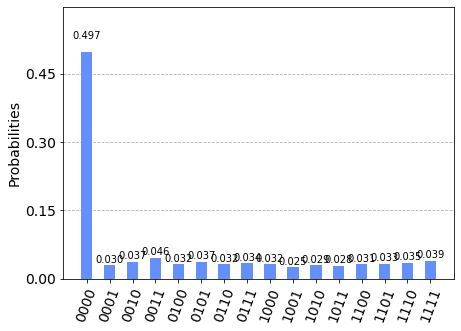

In [47]:
plot_histogram(counts)